<a href="https://colab.research.google.com/github/xixilili/MSDS_458_Public/blob/master/MSDS458_Assignment_03/MSDS458_Assignment_03_Experiment_D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Experiment D: 1D CNN

### Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Load Package

In [2]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds

### Load and Process Data

In [3]:
# register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

# Example Approaches to Split Data Set
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:]','test[:1000]', 'test[1000:]'],
dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:95%]','train[95%:]', 'test[:]'],
# dataset, info = tfds.load('ag_news_subset', with_info=True,  split=['train[:114000]','train[114000:]', 'test[:]'],
                          as_supervised=True)
train_dataset, validation_dataset, test_dataset = dataset
# train_dataset, test_dataset = dataset['train'],dataset['test']

2022-02-19 07:10:21.576050: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
I0219 07:10:21.576297 140626817791872 download_and_prepare.py:200] Running download_and_prepare for dataset(s):
ag_news_subset
I0219 07:10:21.577527 140626817791872 dataset_info.py:361] Load dataset info from /root/tensorflow_datasets/ag_news_subset/1.0.0
I0219 07:10:21.579457 140626817791872 download_and_prepare.py:138] download_and_prepare for dataset ag_news_subset/1.0.0...
I0219 07:10:21.579812 140626817791872 dataset_builder.py:299] Reusing dataset ag_news_subset (/root/tensorflow_datasets/ag_news_subset/1.0.0)
name: "ag_news_subset"
description: "AG is a collection of more than 1 million news articles.\nNews articles have been gathered from more than 2000  news sources by ComeToMyHead in more than 1 year of activity.\nComeToMyHead is an academic news search engine which has been running since July, 2004.\nThe dataset is 

In [4]:
BUFFER_SIZE = 10000
BATCH_SIZE = 2560
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

### Explore Vocab

In [5]:
def explore_vocab(train_dataset,encoder):
  doc_sizes = []
  corpus = []
  for example, _ in train_dataset.as_numpy_iterator():
    enc_example = encoder(example)
    doc_sizes.append(len(enc_example))
    corpus+=list(enc_example.numpy())
  return  corpus, doc_sizes

### Compile, Train Model

In [6]:
def namestr(obj, namespace):
  for name in namespace:
    if namespace[name] is obj:
      return name

In [7]:
import datetime as dt

def compile_train_model(model, epoch):
  #compile model
  model.compile(optimizer="adam"
              ,loss="categorical_crossentropy" # if we set from_logits=True we don not have specify a softmax activation function in the last layer
              ,metrics=['accuracy'])

  start_datetime = dt.datetime.now()

  #train model  
  history = model.fit(train_dataset
                    ,epochs = epoch
                    ,validation_data=validation_dataset
                    ,callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]
                    )


  #evaluate model
  loss, accuracy = model.evaluate(test_dataset)
  print('test set accuracy: ', accuracy * 100)

  runtime = (dt.datetime.now() - start_datetime).total_seconds()

  #training and validation performance metrix
  history_dict = history.history
  history_df=pd.DataFrame(history_dict)

  #loss and accuracy for training and validation data
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  result = history_df.tail(1)
  result['test_loss'] = loss
  result['test_accuracy'] = accuracy
  result['process_time'] = runtime
  result['epochs_setting'] = epoch  
  result['epochs_actual'] = epochs    

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
      plt.subplot(1, 2, i + 1)
      plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
      plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
      plt.legend()
      plt.title('{0} with {1} epochs'.format(namestr(model, globals()), epoch))   
  plt.show()  

  return result

## 1D CNN

### Encoder

In [8]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))
vocab = np.array(encoder.get_vocabulary());

In [9]:
corpus, doc_sizes = explore_vocab(train_dataset,encoder)

In [10]:
vocab = np.array(encoder.get_vocabulary())
num_vocab_words_in_corpus =len(vocab)

num_words =len(corpus)
num_articles =len(doc_sizes)
min_token_in_a_article = min(doc_sizes)
max_token_in_a_article = max(doc_sizes)  

print(num_vocab_words_in_corpus)
print(num_words)
print(num_articles)
print(min_token_in_a_article)
print(max_token_in_a_article)

1000
114000
45
1360
2560


### Create Model

In [11]:
CNN1D = tf.keras.Sequential([
                              encoder
                              ,tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=64,mask_zero=True)
                              ,tf.keras.layers.Conv1D(8, 24, activation="relu")
                              ,tf.keras.layers.MaxPooling1D(2)
                              ,tf.keras.layers.Conv1D(8, 12, activation="relu")
                              ,tf.keras.layers.MaxPooling1D(2)
                              ,tf.keras.layers.Conv1D(8, 6, activation="relu")
                              ,tf.keras.layers.GlobalAveragePooling1D()
                              ,tf.keras.layers.Flatten()
                              ,tf.keras.layers.Dense(1,activation='softmax')   
])

### 1D CNN

Epoch 1/200
45/45 [==============================] - 76s 2s/step - loss: 0.0000e+00 - accuracy: 0.2500 - val_loss: 0.0000e+00 - val_accuracy: 0.2508
Epoch 2/200
45/45 [==============================] - 76s 2s/step - loss: 0.0000e+00 - accuracy: 0.2500 - val_loss: 0.0000e+00 - val_accuracy: 0.2508
Epoch 3/200
3/3 [==============================] - 1s 376ms/step - loss: 0.0000e+00 - accuracy: 0.2500
test set accuracy:  25.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

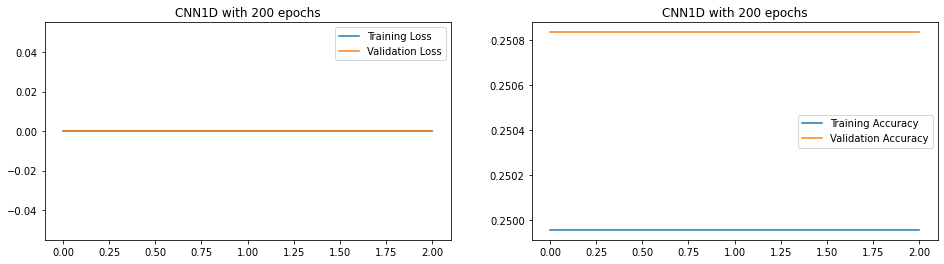

In [12]:
result_CNN1D = compile_train_model(CNN1D, 200)

In [13]:
result_CNN1D['vocab_size'] = VOCAB_SIZE 
result_CNN1D['num_words'] = num_words 
result_CNN1D['num_articles'] = num_articles
result_CNN1D['min_token_in_a_article'] = min_token_in_a_article 
result_CNN1D['max_token_in_a_article'] = max_token_in_a_article 
new_col = ['1D CNN']   
result_CNN1D.insert(loc=0, column='Model', value=new_col)

In [19]:
result_CNN1D

,Model,loss,accuracy,val_loss,val_accuracy,test_loss,test_accuracy,process_time,epochs_setting,epochs_actual,vocab_size,num_words,num_articles,min_token_in_a_article,max_token_in_a_article
2,1D CNN,0.0,0.249956,0.0,0.250833,0.0,0.25,237.795609,200,3,1000,114000,45,1360,2560


In [14]:
#prev_results_df = pd.read_pickle('/content/gdrive/My Drive/Colab Notebooks/resultsB.pkl')
#assignment_result_table = prev_results_df.append(result_CNN1D,ignore_index=True)
#assignment_result_table

### Save Data

In [15]:
result_CNN1D.to_pickle("/content/gdrive/My Drive/Colab Notebooks/resultsD.pkl") 
result_CNN1D.to_csv("/content/gdrive/My Drive/Colab Notebooks/resultsD.csv") 

### Reference code

In [16]:
"""
CNN1D = tf.keras.Sequential([ tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=64,mask_zero=True, return_sequences=True)
                              ,tf.keras.layers.Conv1D(8, 24, activation="relu")
                              ,tf.keras.layers.MaxPooling1D(2)
                              ,tf.keras.layers.Flatten()
                              ,tf.keras.layers.Dense(1,activation='softmax')   
])
"""

'\nCNN1D = tf.keras.Sequential([ tf.keras.layers.Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=64,mask_zero=True, return_sequences=True)\n                              ,tf.keras.layers.Conv1D(8, 24, activation="relu")\n                              ,tf.keras.layers.MaxPooling1D(2)\n                              ,tf.keras.layers.Flatten()\n                              ,tf.keras.layers.Dense(1,activation=\'softmax\')   \n])\n'

In [17]:
"""
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Embedding, Dropout, Flatten, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

modelD = models.Sequential()
modelD.add(Embedding(input_dim = len(encoder.get_vocabulary()), output_dim = 64, input_length=193))
modelD.add(Conv1D(filters = 32, kernel_size = 3, activation='relu')) #
modelD.add(Flatten())
modelD.add(Dense(units = 512, activation='relu')) #
modelD.add(Dropout(0.5)) #
modelD.add(Dense(units = 21, activation='softmax'))

modelD.summary()
"""

"\nimport tensorflow as tf\nfrom tensorflow import keras\nfrom tensorflow.keras import models, layers\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Conv1D, Embedding, Dropout, Flatten, Input, Dense\nfrom tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping\nfrom tensorflow.keras.preprocessing import image\nfrom tensorflow.keras.utils import to_categorical\n\nmodelD = models.Sequential()\nmodelD.add(Embedding(input_dim = len(encoder.get_vocabulary()), output_dim = 64, input_length=193))\nmodelD.add(Conv1D(filters = 32, kernel_size = 3, activation='relu')) #\nmodelD.add(Flatten())\nmodelD.add(Dense(units = 512, activation='relu')) #\nmodelD.add(Dropout(0.5)) #\nmodelD.add(Dense(units = 21, activation='softmax'))\n\nmodelD.summary()\n"

In [18]:
"""
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
"""

'\ninputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))\nx = layers.Conv1D(8, 24, activation="relu")(inputs)\nx = layers.MaxPooling1D(2)(x)\nx = layers.Conv1D(8, 12, activation="relu")(x)\nx = layers.MaxPooling1D(2)(x)\nx = layers.Conv1D(8, 6, activation="relu")(x)\nx = layers.GlobalAveragePooling1D()(x)\noutputs = layers.Dense(1)(x)\nmodel = keras.Model(inputs, outputs)\n'